In [87]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
from datasets import load_dataset

# Load MNIST-M dataset
ds = load_dataset("Mike0307/MNIST-M")
train_data = ds['train']
test_data = ds['test']

X_train_m = np.array([np.array(image.resize((28, 28))) for image in train_data['image']])
y_train_m = np.array(train_data['label'])
X_test_m = np.array([np.array(image.resize((28, 28))) for image in test_data['image']])
y_test_m = np.array(test_data['label'])

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess MNIST
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train = np.repeat(X_train, 3, axis=-1)  # Convert to 3 channels
X_test = np.repeat(X_test, 3, axis=-1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Preprocess MNIST-M
X_train_m = X_train_m.astype(np.float32)/255
X_test_m = X_test_m.astype(np.float32)/255
y_train_m = to_categorical(y_train_m)
y_test_m = to_categorical(y_test_m)

print('MNIST shapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('MNIST-M shapes:', X_train_m.shape, y_train_m.shape, X_test_m.shape, y_test_m.shape)

MNIST shapes: (60000, 28, 28, 3) (60000, 10) (10000, 28, 28, 3) (10000, 10)
MNIST-M shapes: (59001, 28, 28, 3) (59001, 10) (9001, 28, 28, 3) (9001, 10)


In [88]:
import numpy as np
import random
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
from skimage.util import random_noise
from PIL import Image
import matplotlib.pyplot as plt

class RandomRGBTint:
    def __call__(self, img):
        r, g, b = random.uniform(0.5, 1.5), random.uniform(0.5, 1.5), random.uniform(0.5, 1.5)
        img = F.to_tensor(img)
        img[0] *= r
        img[1] *= g
        img[2] *= b
        return torch.clamp(img, 0, 1)

def generate_structured_background(size=(28, 28, 3)):
    bg = np.random.randn(*size) * 0.3
    bg = np.cumsum(bg, axis=0)
    bg = np.clip(bg, 0, 1)
    color_mask = np.random.choice([0.7, 0.8, 0.9], size=size)
    return np.clip(bg * color_mask, 0, 1)

def adaptive_blend(img, alpha_range=(0.5, 0.8)):
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)

    alpha = np.random.uniform(*alpha_range)
    bg = generate_structured_background()
    mask = np.random.rand(28, 28) > 0.2
    blended = np.where(mask[..., None], alpha*img + (1-alpha)*bg, bg)
    blended = random_noise(blended, mode='gaussian', var=0.001)
    return np.clip(blended, 0, 1)

pytorch_transform = T.Compose([
    T.Resize((28, 28)),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    T.ColorJitter(0.3, 0.3, 0.3, 0.1),
    RandomRGBTint()
])


def full_augmentation(images, apply_blend_prob=0.8):
    augmented = []
    for img in images:
        img = np.squeeze(img)
        if np.random.rand() < apply_blend_prob:
            img = adaptive_blend(img)
        else:
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)

        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        transformed = pytorch_transform(pil_img)
        augmented.append(transformed.permute(1, 2, 0).numpy())  
    return np.array(augmented, dtype=np.float32)

from keras.datasets import mnist
(X_train, _), (X_test, _) = mnist.load_data()

X_train_aug = full_augmentation(X_train)  
X_test_aug = full_augmentation(X_test)



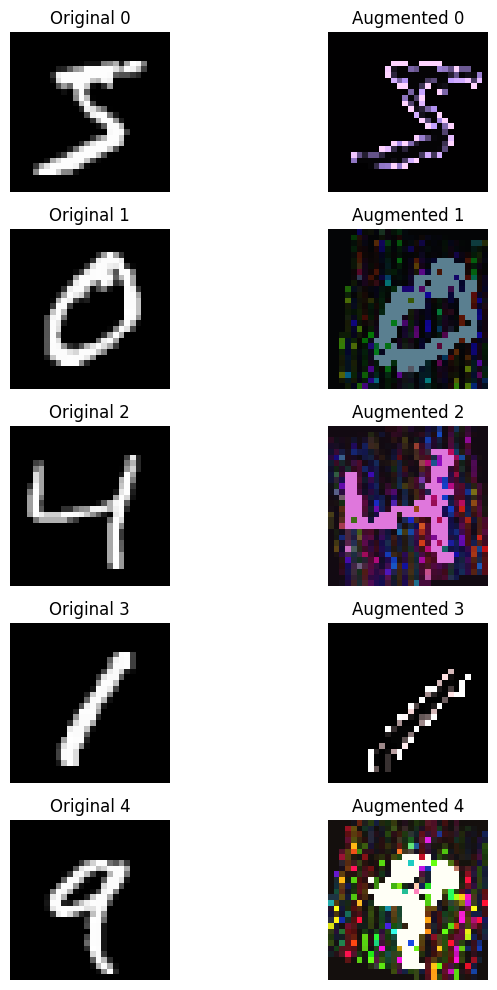

In [89]:
import matplotlib.pyplot as plt

num_samples = 5
plt.figure(figsize=(8, 10))

for i in range(num_samples):
    original = X_train[i] / 255.0 if X_train[i].max() > 1 else X_train[i]
    augmented = X_train_aug[i]

    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(original, cmap='gray', vmin=0, vmax=1)
    plt.title(f"Original {i}")
    plt.axis('off')

    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(augmented, vmin=0, vmax=1)
    plt.title(f"Augmented {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [90]:
X_train = X_train_aug
X_test = X_test_aug


In [91]:
print('MNIST shapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('MNIST-M shapes:', X_train_m.shape, y_train_m.shape, X_test_m.shape, y_test_m.shape)

MNIST shapes: (60000, 28, 28, 3) (60000, 10) (10000, 28, 28, 3) (10000, 10)
MNIST-M shapes: (59001, 28, 28, 3) (59001, 10) (9001, 28, 28, 3) (9001, 10)


In [92]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(28, 28, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
features = Dense(128, activation='relu')(x)

feature_model = Model(inputs=input_layer, outputs=features)

feature_input = Input(shape=(128,))
x = Dropout(0.3)(feature_input)
predictions = Dense(10, activation='softmax')(x)
classifier_model = Model(inputs=feature_input, outputs=predictions)

classifier_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [93]:
classifier_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290 (5.04 KB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
feature_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       147,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,728 (944.25 KB)

 Trainable params: 241,280 (942.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [95]:
import tensorflow as tf
from tensorflow.keras import backend as K

def coral_loss(source, target, scale_loss=1e4):
    batch_size = tf.cast(tf.shape(source)[0], tf.float32)
    d = tf.cast(tf.shape(source)[1], tf.float32)

    source_c = source - tf.reduce_mean(source, axis=0)
    target_c = target - tf.reduce_mean(target, axis=0)

    source_cov = tf.matmul(source_c, source_c, transpose_a=True) / (batch_size - 1.0)
    target_cov = tf.matmul(target_c, target_c, transpose_a=True) / (batch_size - 1.0)
    source_cov += tf.eye(tf.shape(source_cov)[0]) * 1e-5
    target_cov += tf.eye(tf.shape(target_cov)[0]) * 1e-5

    loss = tf.reduce_sum(tf.square(source_cov - target_cov)) / (4.0 * d * d)
    return loss * scale_loss  


In [96]:
def train_model(
    source_x, source_y, target_x, target_y=None,
    feature_model=None, classifier_model=None,
    epochs=10, batch_size=64, lambda_da=0.1, use_coral=True,  # Start with lambda_da=0.1
    validation_data=None,
    validation_samples=9000,
    early_stopping_patience=7,
):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    best_target_acc = 0.0
    patience_counter = 0


    idx_source_fixed = tf.random.shuffle(tf.range(len(source_x)))
    idx_target_fixed = tf.random.shuffle(tf.range(len(target_x)))

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        class_loss_total, da_loss_total = 0.0, 0.0

        idx_source = idx_source_fixed
        idx_target = idx_target_fixed
        num_batches = min(len(source_x) // batch_size, len(target_x) // batch_size)
        lambda_da = min(1.0, epoch / 10.0) * 0.5
        for batch in range(num_batches):
            start = batch * batch_size
            end = start + batch_size

            with tf.GradientTape() as tape:
            
                source_x_batch = tf.gather(source_x, idx_source[start:end])
                source_y_batch = tf.gather(source_y, idx_source[start:end])
                target_x_batch = tf.gather(target_x, idx_target[start:end])

                source_features = feature_model(source_x_batch, training=True)
                target_features = feature_model(target_x_batch, training=True)
                source_pred = classifier_model(source_features, training=True)

                class_loss = tf.reduce_mean(
                    tf.keras.losses.categorical_crossentropy(source_y_batch, source_pred)
                )
                da_loss = (
                    coral_loss(source_features, target_features) 
                    if use_coral 
                    else mmd_loss(source_features, target_features)*1000
                )
                current_lambda = min(lambda_da, lambda_da * epoch / 10)
                total_loss = class_loss + current_lambda * da_loss

            trainable_vars = (
                feature_model.trainable_variables + 
                classifier_model.trainable_variables
            )
            gradients = tape.gradient(total_loss, trainable_vars)
            gradients, _ = tf.clip_by_global_norm(gradients, 5.0)  
            optimizer.apply_gradients(zip(gradients, trainable_vars))

            class_loss_total += class_loss.numpy()
            da_loss_total += da_loss.numpy()

        avg_class_loss = class_loss_total / num_batches
        avg_da_loss = da_loss_total / num_batches
        print(f"Class Loss: {avg_class_loss:.4f}, {'CORAL' if use_coral else 'MMD'} Loss: {avg_da_loss:.4f}")

        if validation_data is not None:
            X_test_m, y_test_m = validation_data
            val_indices = tf.range(validation_samples) 

            target_features = feature_model(tf.gather(X_test_m, val_indices), training=False)
            target_pred = classifier_model(target_features, training=False)
            target_acc = tf.reduce_mean(
                tf.keras.metrics.categorical_accuracy(tf.gather(y_test_m, val_indices), target_pred)
            ).numpy()

            source_indices = tf.range(validation_samples) 
            source_features = feature_model(tf.gather(source_x, source_indices), training=False)
            source_pred = classifier_model(source_features, training=False)
            source_acc = tf.reduce_mean(
                tf.keras.metrics.categorical_accuracy(tf.gather(source_y, source_indices), source_pred)
            ).numpy()

            print(f"Source Acc: {source_acc:.4f}, Target Acc: {target_acc:.4f}")

            # Save best model during training
            if target_acc > best_target_acc:
                best_target_acc = target_acc
                patience_counter = 0
               
                feature_model.save_weights('best_feature_model.weights.h5')  
                classifier_model.save_weights('best_classifier.weights.h5')  
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

    return feature_model, classifier_model

In [97]:
source_x, source_y = X_train, y_train  
target_x = X_train_m                  
target_test_x = X_test_m               

In [98]:
print("Feature model output shape:", feature_model.output_shape)
print("Classifier input shape:", classifier_model.input_shape)

Feature model output shape: (None, 128)
Classifier input shape: (None, 128)


In [99]:
feature_model_coral , classifier_model_coral =train_model(
    source_x=X_train,        
    source_y=y_train,      
    target_x=X_train_m,        
    feature_model=feature_model,
    classifier_model=classifier_model,
    epochs=20,
    batch_size=64,
    lambda_da=0.5,            
    use_coral= True,            
    validation_data=(X_test_m, y_test_m)  
)


Epoch 1/20
Class Loss: 0.5156, CORAL Loss: 381.6895
Source Acc: 0.9231, Target Acc: 0.5370

Epoch 2/20
Class Loss: 0.2655, CORAL Loss: 19.8274
Source Acc: 0.9533, Target Acc: 0.5702

Epoch 3/20
Class Loss: 0.1989, CORAL Loss: 3.8062
Source Acc: 0.9661, Target Acc: 0.5763

Epoch 4/20
Class Loss: 0.1536, CORAL Loss: 1.3574
Source Acc: 0.9756, Target Acc: 0.5802

Epoch 5/20
Class Loss: 0.1203, CORAL Loss: 0.6007
Source Acc: 0.9761, Target Acc: 0.5747

Epoch 6/20
Class Loss: 0.0977, CORAL Loss: 0.3112
Source Acc: 0.9831, Target Acc: 0.5653

Epoch 7/20
Class Loss: 0.0783, CORAL Loss: 0.1782
Source Acc: 0.9836, Target Acc: 0.5562

Epoch 8/20
Class Loss: 0.0634, CORAL Loss: 0.1110
Source Acc: 0.9798, Target Acc: 0.5656

Epoch 9/20
Class Loss: 0.0555, CORAL Loss: 0.0742
Source Acc: 0.9830, Target Acc: 0.5602

Epoch 10/20
Class Loss: 0.0462, CORAL Loss: 0.0519
Source Acc: 0.9831, Target Acc: 0.5552

Epoch 11/20
Class Loss: 0.0425, CORAL Loss: 0.0375
Source Acc: 0.9867, Target Acc: 0.5640
Early

In [100]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

target_features_coral = feature_model_coral.predict(X_test_m)  

y_pred_probs_coral = classifier_model_coral.predict(target_features_coral)  
y_pred_coral = np.argmax(y_pred_probs_coral, axis=1)  

y_test_labels_coral = np.argmax(y_test_m, axis=1)

accuracy = accuracy_score(y_test_labels_coral, y_pred_coral)
print(f"Test Accuracy: {accuracy * 100:.2f}%\n")
print(classification_report(y_test_labels_coral, y_pred_coral))

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 56.39%

              precision    recall  f1-score   support

           0       0.41      0.69      0.51       878
           1       0.98      0.47      0.64      1016
           2       0.44      0.67      0.53       933
           3       0.48      0.63      0.55       908
           4       0.76      0.48      0.58       890
           5       0.84      0.55      0.66       807
           6       0.89      0.46      0.61       856
           7       0.74      0.51      0.60       914
           8       0.40      0.68      0.50       880
           9       0.63      0.51      0.56       919

    accuracy                           0.56      9001
   macro avg       0.66      0.56      0.57      9001
weighted avg       0.66      0.56      0.57      9001



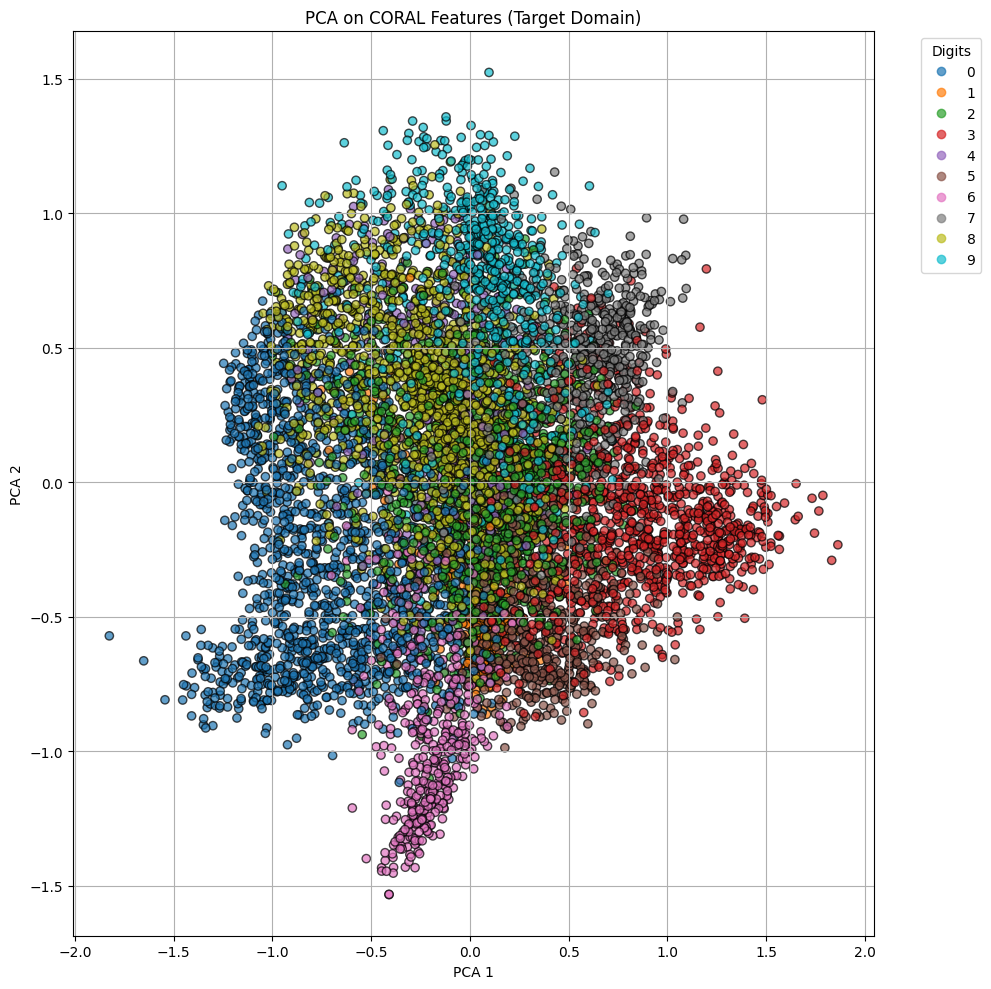

In [101]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(target_features_coral)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_pred_coral, cmap='tab10', edgecolors='k', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("PCA on CORAL Features (Target Domain)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


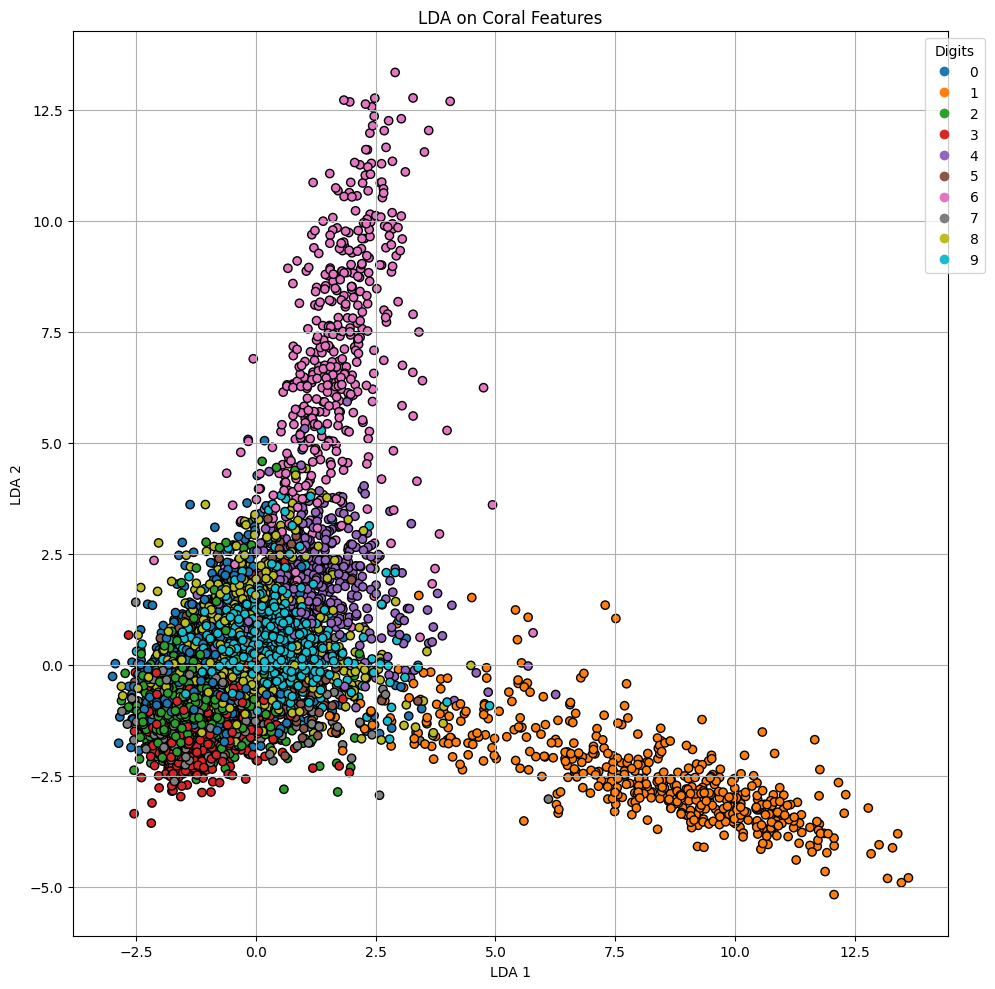

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
lda_result = lda.fit_transform(features, y_pred_coral)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(lda_result[:, 0], lda_result[:, 1], c=y_pred_coral, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("LDA on Coral Features")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\anshb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


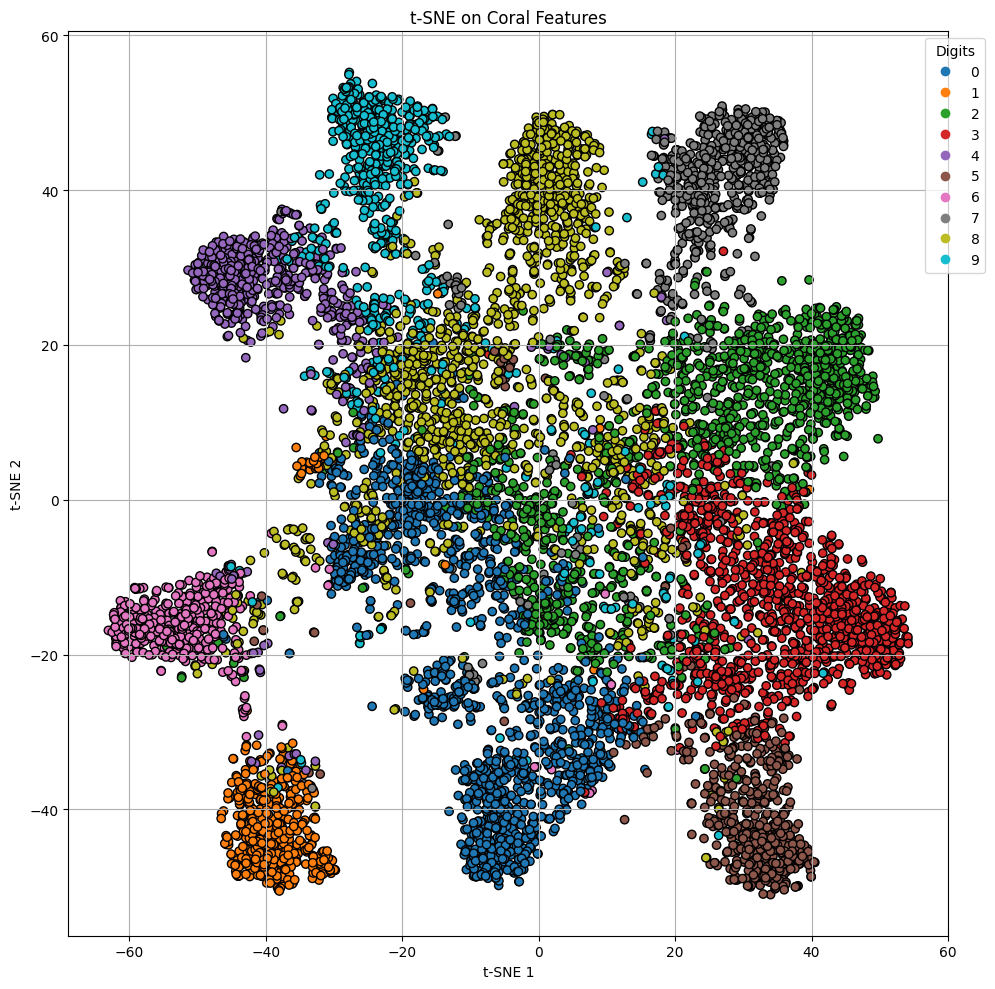

In [104]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_pred_coral, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("t-SNE on Coral Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


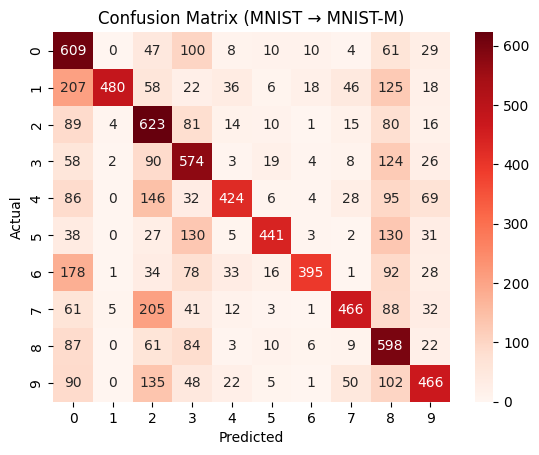

In [105]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if len(y_test_m.shape) > 1:
    y_test_m_labels = np.argmax(y_test_m, axis=1)
else:
    y_test_m_labels = y_test_m

if len(y_pred_coral.shape) > 1:
    y_pred_coral_labels = np.argmax(y_pred_coral, axis=1)
else:
    y_pred_coral_labels = y_pred_coral

cm = confusion_matrix(y_test_m_labels, y_pred_coral_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (MNIST → MNIST-M)")
plt.show()


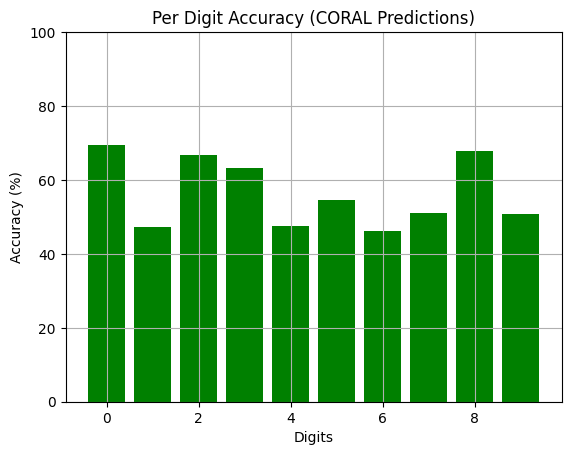

In [106]:
import numpy as np
import matplotlib.pyplot as plt

y_true = np.argmax(y_test_m, axis=1)
y_pred = y_pred_coral  

accuracies = []
for digit in range(10):
    idx = (y_true == digit)
    correct = (y_pred[idx] == digit).sum()
    total = idx.sum()
    accuracies.append(correct / total * 100)

plt.bar(range(10), accuracies, color='green')
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Per Digit Accuracy (CORAL Predictions)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()


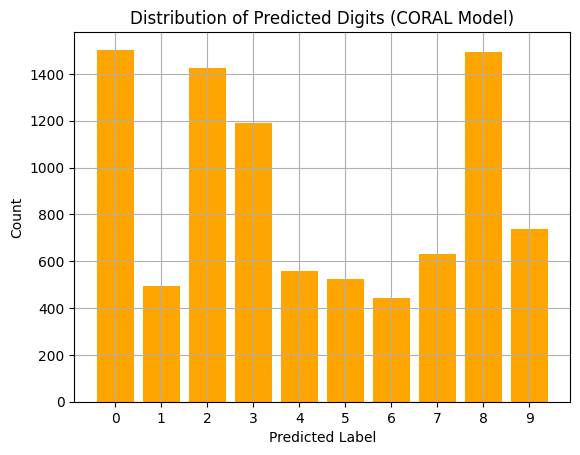

In [107]:
import numpy as np
import matplotlib.pyplot as plt

if len(y_pred_coral.shape) > 1:
    y_pred = np.argmax(y_pred_coral, axis=1)
else:
    y_pred = y_pred_coral  

plt.hist(y_pred, bins=np.arange(11) - 0.5, rwidth=0.8, color='orange')
plt.xticks(range(10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Distribution of Predicted Digits (CORAL Model)")
plt.grid(True)
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


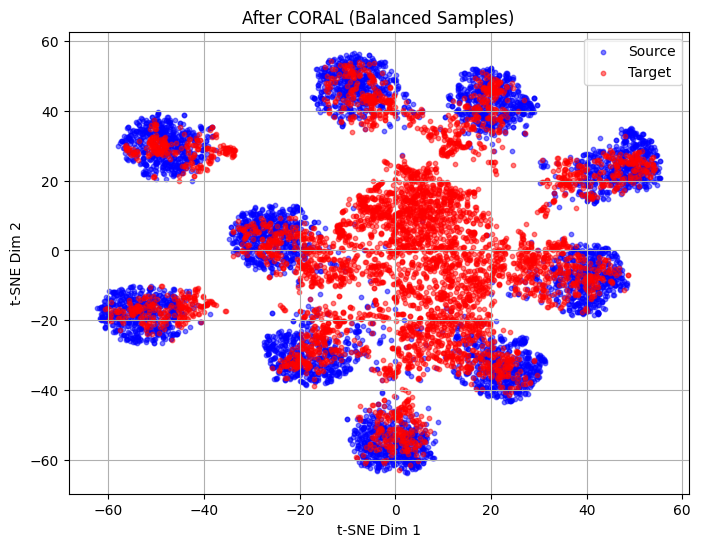

In [108]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_domain_alignment(source_features, target_features, title='Domain Alignment'):
  
    all_features = np.concatenate([source_features, target_features], axis=0)
    
    domain_labels = np.array([0]*len(source_features) + [1]*len(target_features))
    
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    reduced = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[domain_labels == 0, 0], reduced[domain_labels == 0, 1], 
                label='Source', alpha=0.5, s=10, c='blue')
    plt.scatter(reduced[domain_labels == 1, 0], reduced[domain_labels == 1, 1], 
                label='Target', alpha=0.5, s=10, c='red')
    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.grid(True)
    plt.show()

def balanced_sample(X, y, samples_per_class=500):
    selected = []
    for digit in range(10):
        indices = np.where(np.argmax(y, axis=1) == digit)[0]
        selected.extend(np.random.choice(indices, samples_per_class, replace=False))
    return X[selected], y[selected]

# Balanced sampling: 500 per class → 5000 total
X_src_bal, y_src_bal = balanced_sample(X_train, y_train, samples_per_class=500)
X_tgt_bal, y_tgt_bal = balanced_sample(X_train_m, y_train_m, samples_per_class=500)

features_src = feature_model.predict(X_src_bal)
features_tgt = feature_model.predict(X_tgt_bal)
plot_domain_alignment(features_src, features_tgt, title='After CORAL (Balanced Samples)')
